# Prédire une prime d’assurance

In [18]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

In [20]:
df = pd.read_csv("./4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Partie Analyse

### Vérification des informations manquantes et des doublons

#### Analyse des valeurs manquantes

<Axes: >

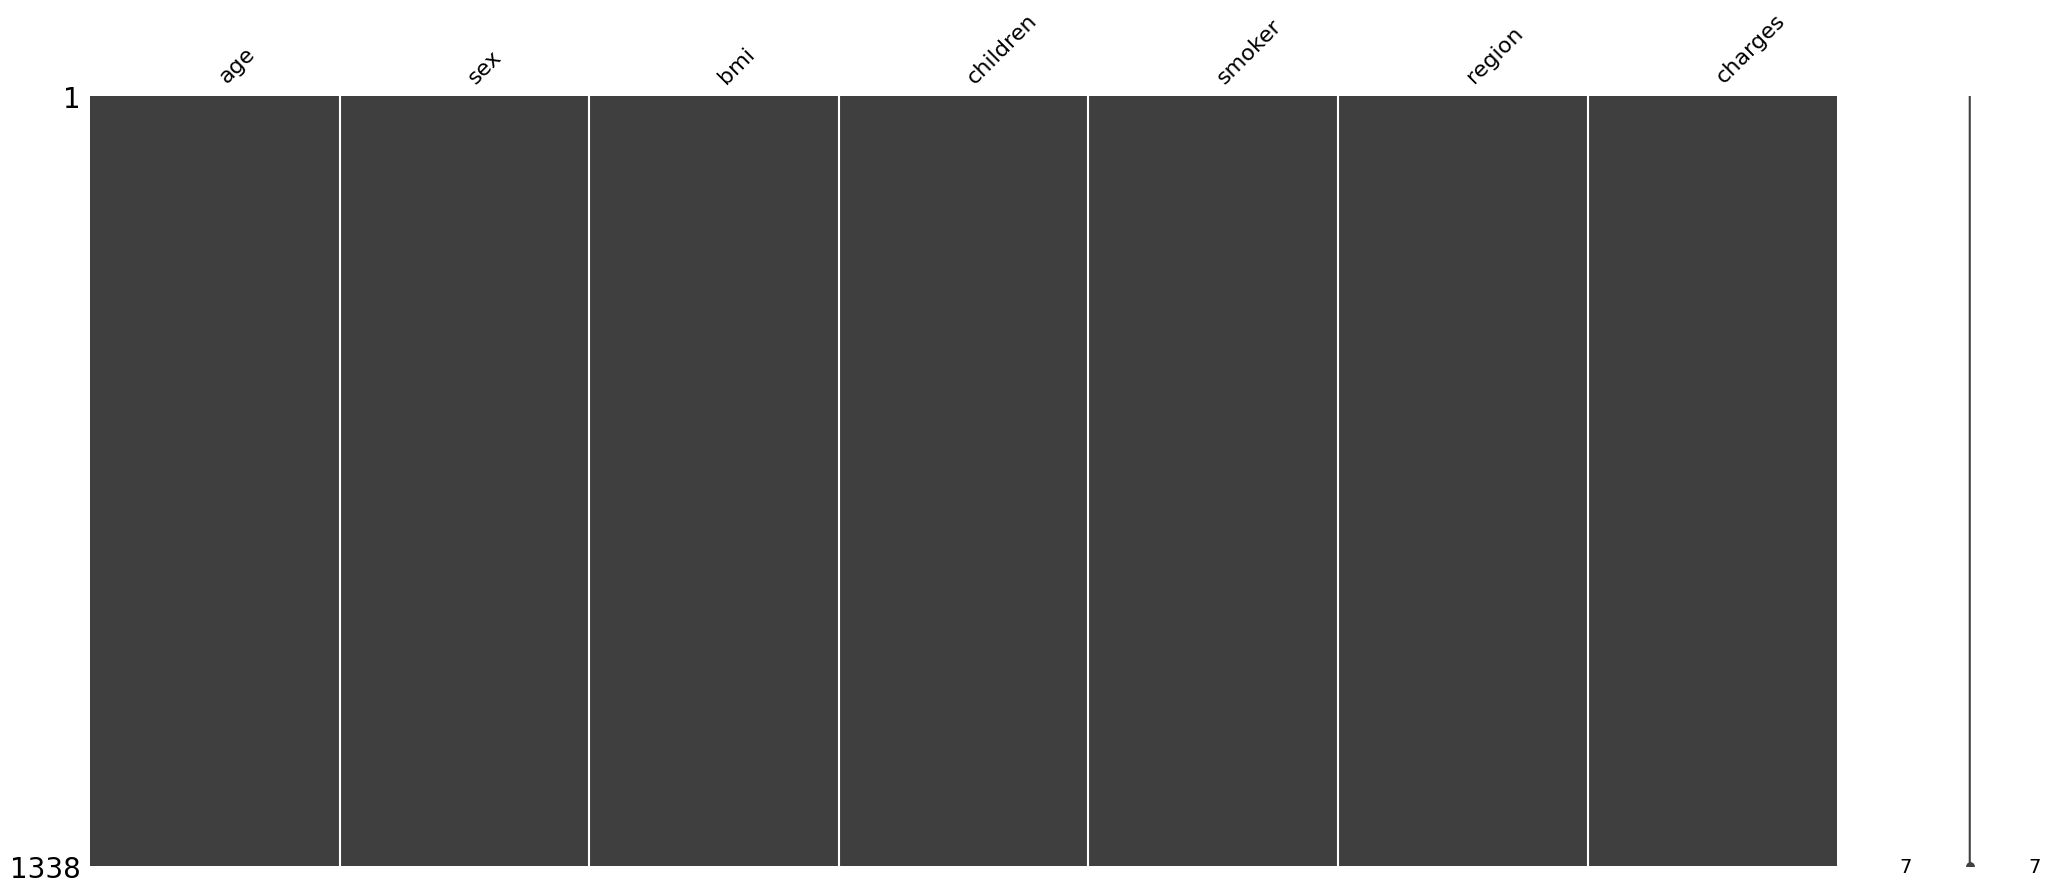

In [21]:
msno.matrix(df)

Il ne semble pas y avoir de valeurs manquantes. Verifions le dans la méthode info()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


En effet il n'y a aucune valeur nulle.

#### Etude des doublons

In [23]:
for i, bool in enumerate(df.duplicated()):
    if bool:
        print(f"la valeur à l'index {i} est en double")

la valeur à l'index 581 est en double


Il y a un doublon ! On l'enlève !

In [24]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

### Etude des valeurs aberrantes 

<Axes: >

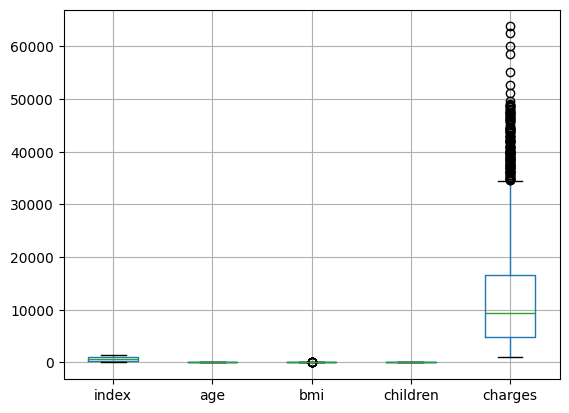

In [25]:
df.boxplot()

On a quelques valeurs aberrantes pour charges et bmi. Recupérons les pour les examiner plus en détail.

In [26]:
cat = "charges"

#On calcule Q1
q1=df[cat].quantile(q=0.25)

#On calcule Q3
q3=df[cat].quantile(q=0.75)

#On calcule l'écart interquartile (IQR)
IQR=q3-q1

#On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile
borne_sup = q3 +1.5*IQR

df_aberrantes= df[df[cat]>borne_sup]
df_aberrantes

,index,age,sex,bmi,children,smoker,region,charges
14,14,27,male,42.130,0,yes,southeast,39611.75770
19,19,30,male,35.300,0,yes,southwest,36837.46700
23,23,34,female,31.920,1,yes,northeast,37701.87680
29,29,31,male,36.300,2,yes,southwest,38711.00000
30,30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...,...
1299,1300,45,male,30.360,0,yes,southeast,62592.87309
1300,1301,62,male,30.875,3,yes,northwest,46718.16325
1302,1303,43,male,27.800,0,yes,southwest,37829.72420
1312,1313,19,female,34.700,2,yes,southwest,36397.57600


In [27]:
cat = "bmi"

#On calcule Q1
q1=df[cat].quantile(q=0.25)

#On calcule Q3
q3=df[cat].quantile(q=0.75)

#On calcule l'écart interquartile (IQR)
IQR=q3-q1

#On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile
borne_sup = q3 +1.5*IQR

df_aberrantes= df[df[cat]>borne_sup]
df_aberrantes

,index,age,sex,bmi,children,smoker,region,charges
116,116,58,male,49.06,0,no,southeast,11381.32540
286,286,46,female,48.07,2,no,northeast,9432.92530
401,401,47,male,47.52,1,no,southeast,8083.91980
543,543,54,female,47.41,0,yes,southeast,63770.42801
846,847,23,male,50.38,1,no,southeast,2438.05520
859,860,37,female,47.60,2,yes,southwest,46113.51100
1046,1047,22,male,52.58,1,yes,southeast,44501.39820
1087,1088,52,male,47.74,1,no,southeast,9748.91060
1316,1317,18,male,53.13,0,no,southeast,1163.46270


Rien ne nous permets de dire que ces valeurs sont des erreurs d'obvservations. On va donc les conserver pour le moment. On poura les enlever suite à une étude à posterieuri de notre modélisation.

### Analyse univariée 

In [33]:
def univar_scatter(col):
    df_col = df[[col, "charges"]]
    df_col.plot(x = col, y="charges" , kind="scatter")

In [35]:
def univar_bar(col):
    df_col = df.groupby(col)["charges"].mean()
    plt.title(f'Redevances en fonction de {col}')
    df_col.plot(kind= "bar")

#### Age

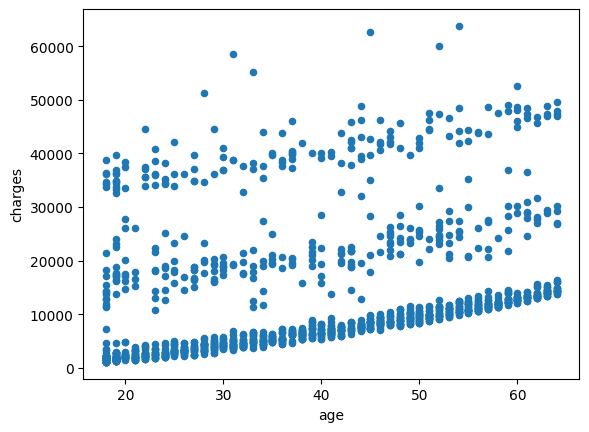

In [34]:
univar_scatter("age")

L'âge à l'air d'avoir un impact sur les redevances. Trois modèles linéaires semble ressortir. On en saura plus lors de l'analyse univarié.

#### genre

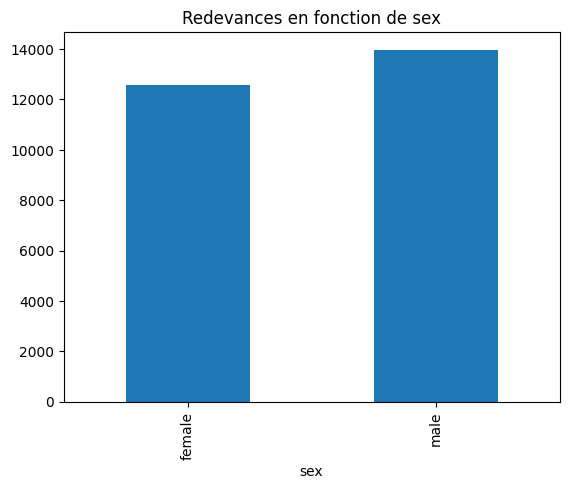

In [36]:
univar_bar("sex")

On a des redevances légèrement plus élevés pour les hommes...

#### bmi

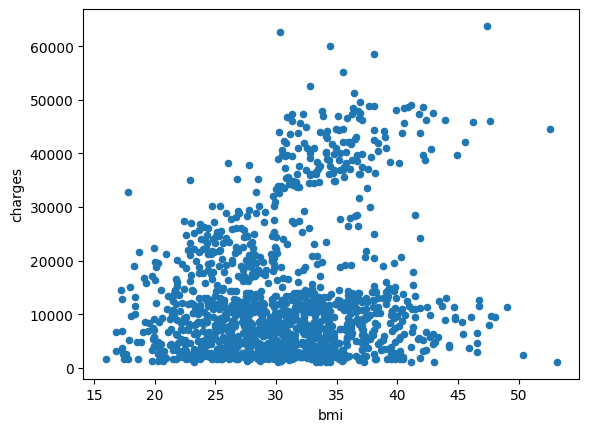

In [38]:
univar_scatter("bmi")

Le bmi semble avoir une importance. Faisons des catégories de poids pour pouvoir en faire un diagramme en colonnes :

In [40]:
# Définir les tranches de BMI
bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']

# Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
df["BMI_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

/tmp/ipykernel_19550/1881248992.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_col = df.groupby(col)["charges"].mean()


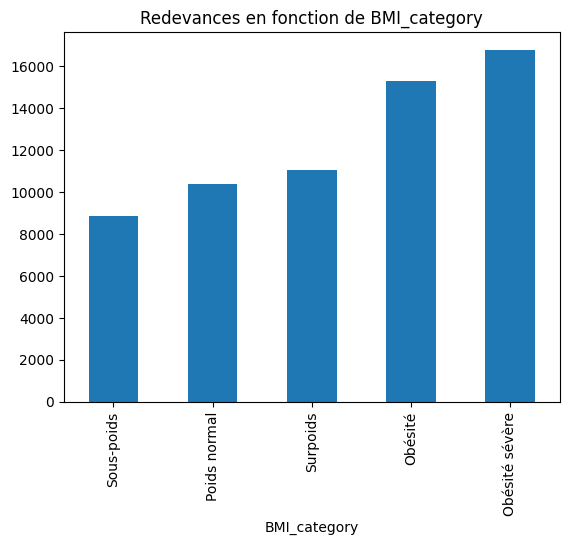

In [41]:
univar_bar("BMI_category")

Le BMI a clairement une importance... Et semble être séparé entre obèse (>30), ou non...

#### Enfants

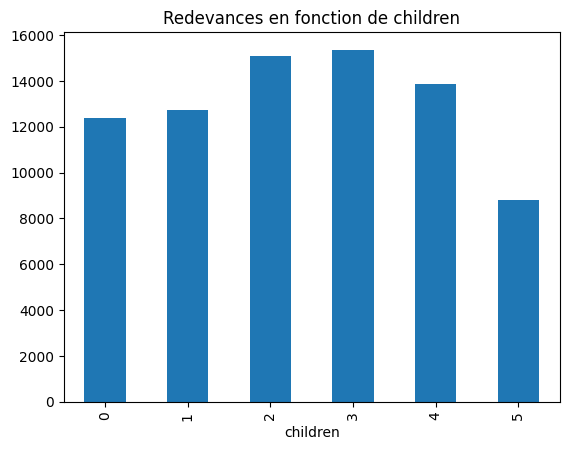

In [43]:
univar_bar("children")

On voit etrangement une parabole ce dessiner...

In [48]:
df.loc[df["children"] == 5,:].shape[0]

18

On 